In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from dataset import CIFAR10C
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from scipy.special import softmax

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loc = "nfs"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=DATA_PATHS[data_loc]["CIFAR10"], train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

val_features = get_imagenet_features(val_loader)


In [4]:
ood_scores_all = {}

idxs = np.random.permutation(10000)
val_features = val_features[idxs]
val_features_train = val_features[1000:]

corruptions = ["impulse_noise", "shot_noise", "defocus_blur", "motion_blur", "speckle_noise"]
for corruption_type in corruptions:
    ood_scores_all[corruption_type] = []
    for corruption_level in range(5):
        ood_loader = torch.utils.data.DataLoader(
            CIFAR10C(data_loc, corruption_type, corruption_level, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=128, shuffle=False,
            num_workers=4, pin_memory=True)
        ood_features = get_imagenet_features(ood_loader)
        idxs = np.random.permutation(10000)
        ood_features = ood_features[idxs]
        ood_features_train = ood_features[1000:]

        X = np.concatenate((val_features_train, ood_features_train), axis=0)
        y = np.concatenate((np.ones(9000), np.zeros(9000)), axis=0)

        scores = []
        for _ in range(30):
            clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
            clf.fit(X, y)
            score = clf.predict_log_proba(ood_features[:1000])[:, 0].mean()
            scores.append(score)
        ood_scores_all[corruption_type].append(np.mean(scores))

In [5]:
corruption_types = ["impulse_noise", "shot_noise", "defocus_blur", "motion_blur", "speckle_noise"]
corruption_type_labels = ["Impulse Noise", "Shot Noise", "Defocus Blur", "Motion Blur", "Speckle Noise"]
corruption_type_labels = [r"\textbf{"+corruption_type_label+"}" for corruption_type_label in corruption_type_labels]

run_names = ["reward_prediction_seed1_2023_05_26_19_52_26",
            "reward_prediction_seed2_2023_05_26_19_52_19", 
            "reward_prediction_seed3_2023_05_26_19_52_39", 
            "reward_prediction_seed4_2023_05_26_19_53_31",
            "reward_prediction_seed5_2023_05_26_19_53_31"]

run_names_imitation = ["xent+1_seed1_2023_05_26_19_51_41",
                       "xent+1_seed2_2023_05_26_19_51_48",
                       "xent+1_seed3_2023_05_26_19_52_09",
                       "xent+1_seed4_2023_05_26_19_51_48",
                       "xent+1_seed5_2023_05_26_19_52_09"]

run_names_oracle = ["xent_seed1_2023_05_26_19_49_29",
                    "xent_seed2_2023_05_26_19_50_57",
                    "xent_seed3_2023_05_26_19_50_57",
                    "xent_seed4_2023_05_26_19_50_57",
                    "xent_seed5_2023_05_26_19_51_22"]

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


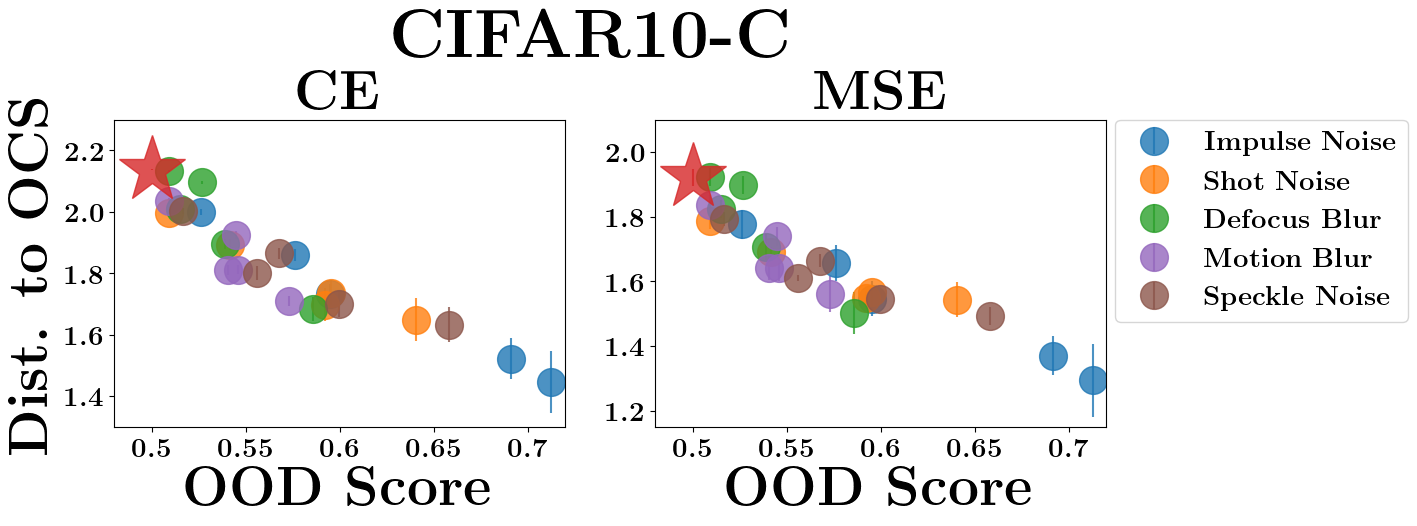

In [6]:


f_star = [-3.5 for _ in range(10)]
f_star.append(0)


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
# plt.figure()
# ax = plt.gca()

# make 2 subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(6.4*2, 4.8))#, gridspec_kw={'width_ratios': [1, 1.5]})


dir_path = os.path.dirname(os.path.abspath("__file__"))


dist_from_f_starts_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs_impulse_noise.pkl"), 'rb') as f:
        data = pickle.load(f)
    dist_from_f_starts_all.append(((data[0] - np.expand_dims(f_star, axis=0))**2).mean())
dist_from_f_starts_all = np.array(dist_from_f_starts_all)
ax1.errorbar([0.5], [dist_from_f_starts_all.mean(axis=0)], yerr=[dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in run_names:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(1, 6):
            dist_from_f_start = ((data[corruption_level] - np.expand_dims(f_star, axis=0))**2).mean()
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)
    dist_from_f_starts_all = np.array(dist_from_f_starts_all)
    ax1.errorbar(np.e**np.array(ood_scores_all[corruption_type]), dist_from_f_starts_all.mean(axis=0), yerr=dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=corruption_type_labels[corruption_type_idx], alpha=0.8, color=colors[corruption_type_idx+1])

ax1.set_xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
# ax1.set_ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)
ax1.set_title(r"\textbf{MSE}", fontsize=40)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
ax1.set_yticks([1.2+_*0.2 for _ in range(5)], [r"\textbf{"+str(1.2+_*0.2)+"}" for _ in range(5)], fontsize=20)
ax1.set_xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
ax1.set_ylim([1.15, 2.1])
ax1.set_xlim([0.48, 0.72])



class_probs = [0.1 for _ in range(10)]

dist_from_f_starts_all = []
for run_name in run_names_oracle:
    with open(os.path.join(dir_path, "data", run_name, "outputs_impulse_noise.pkl"), 'rb') as f:
        data = pickle.load(f)
    dist  = softmax(data[0], axis=-1)
    dist_from_f_start = (np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
    dist_from_f_starts_all.append(dist_from_f_start)
dist_from_f_starts_all = np.array(dist_from_f_starts_all)
ax2.errorbar([0.5], [dist_from_f_starts_all.mean(axis=0)], yerr=[dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in run_names_oracle:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(1, 6):
            dist  = softmax(data[corruption_level], axis=-1)
            dist_from_f_start = (np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)
    dist_from_f_starts_all = np.array(dist_from_f_starts_all)
    ax2.errorbar(np.e**np.array(ood_scores_all[corruption_type]), dist_from_f_starts_all.mean(axis=0), yerr=dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=corruption_type_labels[corruption_type_idx], alpha=0.8, color=colors[corruption_type_idx+1])

ax2.set_xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
ax2.set_ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)
ax2.set_title(r"\textbf{CE}", fontsize=40)
# ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
ax2.set_yticks([1.2+_*0.2 for _ in range(7)], [r"\textbf{"+str(1.2+_*0.2)+"}" for _ in range(7)], fontsize=20)
ax2.set_xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
ax2.set_ylim([1.3, 2.3])
ax2.set_xlim([0.48, 0.72])

# set title to both subplots
fig.suptitle(r"\textbf{CIFAR10-C}", fontsize=50)
# fig.tight_layout()
fig.subplots_adjust(top=0.75)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


(0.48, 0.72)

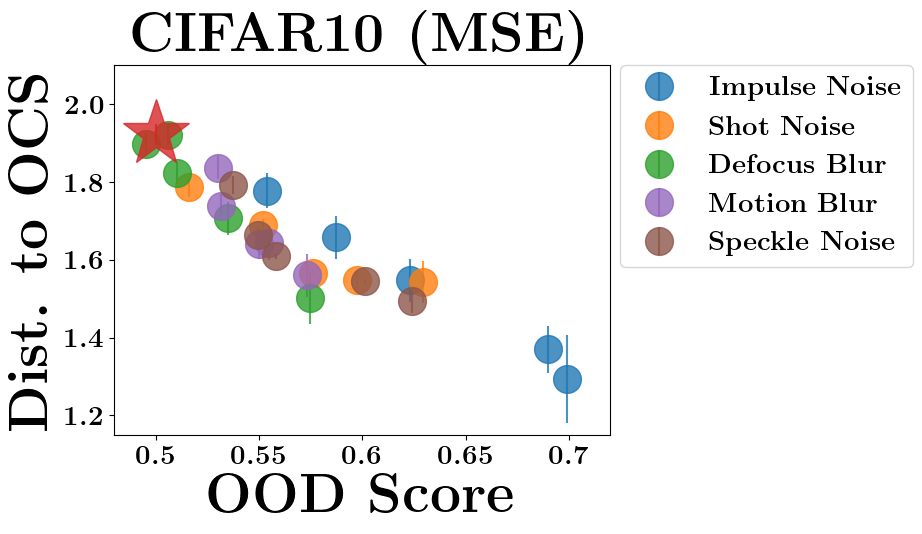

In [9]:
f_star = [-3.5 for _ in range(10)]
f_star.append(0)


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()
dir_path = os.path.dirname(os.path.abspath("__file__"))


dist_from_f_starts_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs_impulse_noise.pkl"), 'rb') as f:
        data = pickle.load(f)
    dist_from_f_starts_all.append(((data[0] - np.expand_dims(f_star, axis=0))**2).mean())
dist_from_f_starts_all = np.array(dist_from_f_starts_all)
plt.errorbar([0.5], [dist_from_f_starts_all.mean(axis=0)], yerr=[dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in run_names:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(1, 6):
            dist_from_f_start = ((data[corruption_level] - np.expand_dims(f_star, axis=0))**2).mean()
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)
    dist_from_f_starts_all = np.array(dist_from_f_starts_all)
    plt.errorbar(np.e**np.array(ood_scores_all[corruption_type]), dist_from_f_starts_all.mean(axis=0), yerr=dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=corruption_type_labels[corruption_type_idx], alpha=0.8, color=colors[corruption_type_idx+1])

plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
plt.ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)
plt.title(r"\textbf{CIFAR10 (MSE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.yticks([1.2+_*0.2 for _ in range(5)], [r"\textbf{"+str(1.2+_*0.2)+"}" for _ in range(5)], fontsize=20)
plt.xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
plt.ylim([1.15, 2.1])
plt.xlim([0.48, 0.72])

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


(0.48, 0.72)

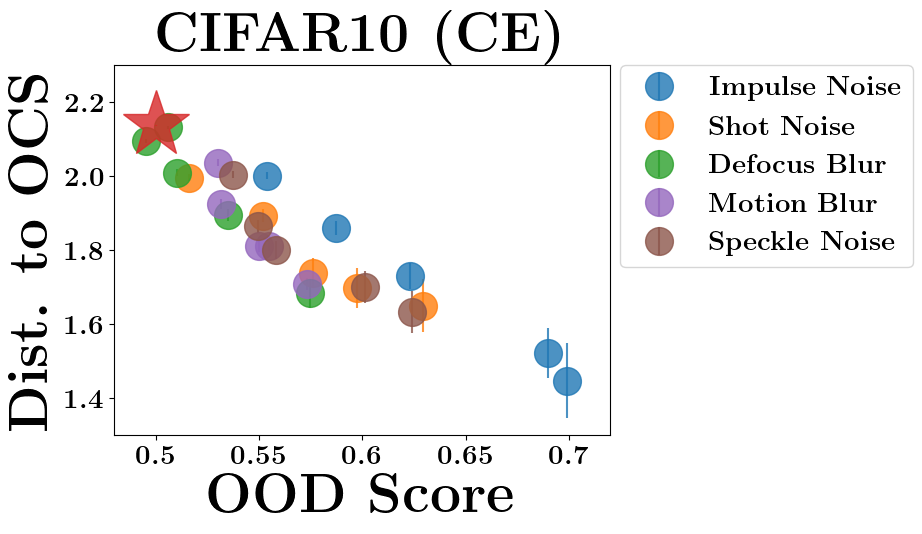

In [14]:


f_star = [-3.5 for _ in range(10)]
f_star.append(0)


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()
dir_path = os.path.dirname(os.path.abspath("__file__"))
class_probs = [0.1 for _ in range(10)]


dist_from_f_starts_all = []
for run_name in run_names_oracle:
    with open(os.path.join(dir_path, "data", run_name, "outputs_impulse_noise.pkl"), 'rb') as f:
        data = pickle.load(f)
    dist  = softmax(data[0], axis=-1)
    dist_from_f_start = (np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
    dist_from_f_starts_all.append(dist_from_f_start)
dist_from_f_starts_all = np.array(dist_from_f_starts_all)
plt.errorbar([0.5], [dist_from_f_starts_all.mean(axis=0)], yerr=[dist_from_f_starts_all.std(axis=0)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])


for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in run_names_oracle:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(1, 6):
            dist  = softmax(data[corruption_level], axis=-1)
            dist_from_f_start = (np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)
    dist_from_f_starts_all = np.array(dist_from_f_starts_all)
    plt.errorbar(np.e**np.array(ood_scores_all[corruption_type]), dist_from_f_starts_all.mean(axis=0), yerr=dist_from_f_starts_all.std(axis=0), fmt="o", markersize=20, label=corruption_type_labels[corruption_type_idx], alpha=0.8, color=colors[corruption_type_idx+1])

plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
plt.ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)
plt.title(r"\textbf{CIFAR10 (CE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.yticks([1.2+_*0.2 for _ in range(7)], [r"\textbf{"+str(1.2+_*0.2)+"}" for _ in range(7)], fontsize=20)
plt.xticks([0.5+0.05*_ for _ in range(5)], [r"\textbf{"+str(0.5+0.05*_)+"}" for _ in range(5)], fontsize=20)
plt.ylim([1.3, 2.3])
plt.xlim([0.48, 0.72])

In [19]:
labels = np.load(DATA_PATHS["nfs"]["CIFAR10"]+"CIFAR-10-C/labels.npy").squeeze()[:10000]
one_hot = np.zeros((len(labels), 11))
one_hot[np.arange(len(labels)), labels] = 1
reward_all = (4+1)*one_hot - 4
reward_all[:, -1] = 0

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


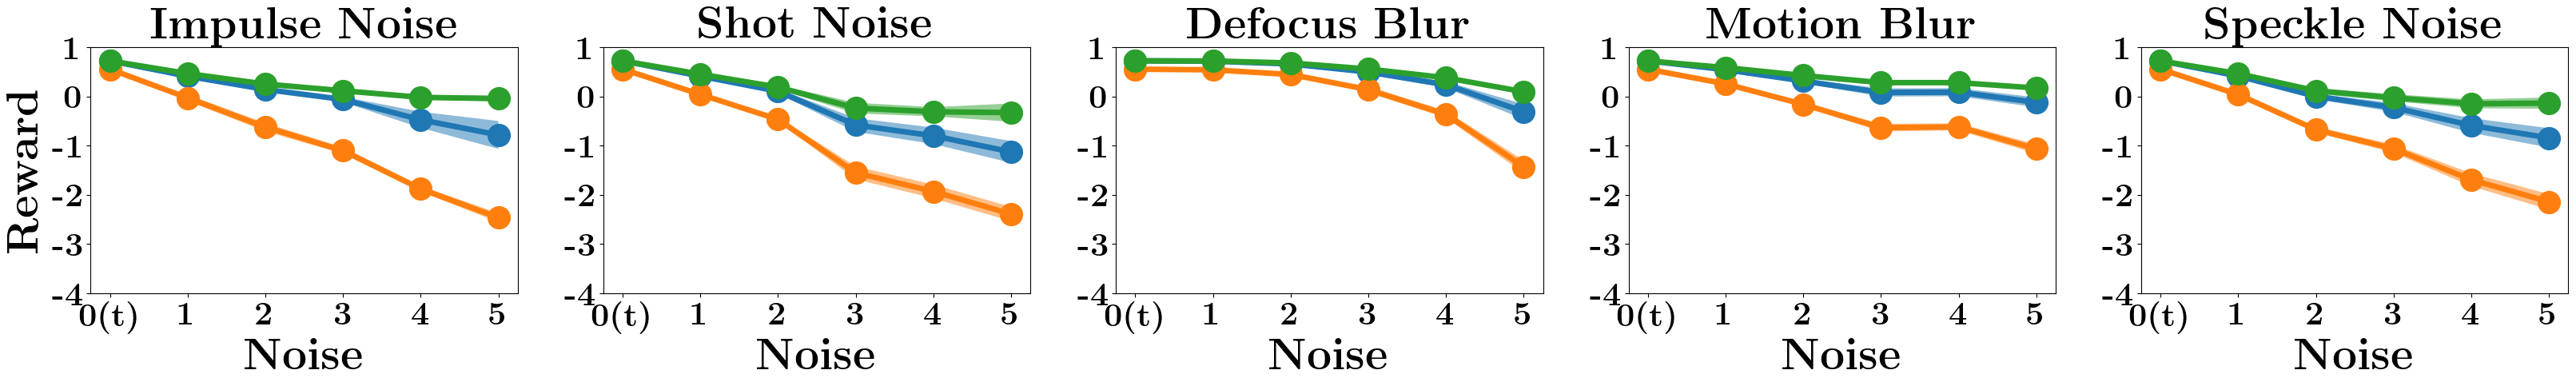

In [50]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
# make subplots with 5 plots horizontally
fig, axs = plt.subplots(1, 5, figsize=(40, 4))


for j in range(5):
    corruption_type = corruption_types[j]

    rl_rewards_seed_corr = np.zeros((5, 6))
    rl_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        rl_run_name = run_names[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}.pkl'.format(rl_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            best_pred_actions = np.argmax(outputs, axis=-1)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            rl_rewards_seed_corr[i, corruption_level] = rewards.mean()
            rl_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()

    bc_rewards_seed_corr = np.zeros((5, 6))
    bc_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        bc_run_name = run_names_imitation[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}.pkl'.format(bc_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            best_pred_actions = np.argmax(outputs, axis=-1)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            bc_rewards_seed_corr[i, corruption_level] = rewards.mean()
            bc_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()

    oracle_rewards_seed_corr = np.zeros((5, 6))
    oracle_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        oracle_run_name = run_names_oracle[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}_ts.pkl'.format(oracle_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            outputs = softmax(outputs, axis=-1)
            output_dist_max = outputs.max(axis=-1)
            best_actions = np.argmax(outputs, axis=-1)
            threshold = 4/(1+4)
            certain = (output_dist_max > threshold)
            best_pred_actions = np.array(certain*best_actions + (1-certain)*np.ones(best_actions.shape)*10).astype(int)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            oracle_rewards_seed_corr[i, corruption_level] = rewards.mean()
            oracle_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()
    
    axs[j].plot(np.arange(6), rl_rewards_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), rl_rewards_seed_corr.mean(axis=0)-rl_rewards_seed_corr.std(axis=0), rl_rewards_seed_corr.mean(axis=0)+rl_rewards_seed_corr.std(axis=0), alpha=0.5)
    axs[j].plot(np.arange(6), bc_rewards_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), bc_rewards_seed_corr.mean(axis=0)-bc_rewards_seed_corr.std(axis=0), bc_rewards_seed_corr.mean(axis=0)+bc_rewards_seed_corr.std(axis=0), alpha=0.5)
    axs[j].plot(np.arange(6), oracle_rewards_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), oracle_rewards_seed_corr.mean(axis=0)-oracle_rewards_seed_corr.std(axis=0), oracle_rewards_seed_corr.mean(axis=0)+oracle_rewards_seed_corr.std(axis=0), alpha=0.5)
    axs[j].set_xticks(np.arange(6), [r'\textbf{0(t)}', r'\textbf{1}', r'\textbf{2}', r'\textbf{3}', r'\textbf{4}', r'\textbf{5}'], fontsize=30)
    axs[j].set_yticks(np.arange(-4, 2, 1),[r'\textbf{'+str(_)+'}' for _ in np.arange(-4, 2, 1)], fontsize=30)
    axs[j].set_xlabel(r'\textbf{Noise}', fontsize=40)
    axs[0].set_ylabel(r'\textbf{Reward}', fontsize=40)
    axs[j].set_ylim(-4, 1)
    axs[j].set_title(corruption_type_labels[j], fontsize=40)

# 
# axs[2].legend(loc="upper center", ncol=3, fontsize=20)
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C2', alpha=1, label=r'\textbf{Oracle}')
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C0', alpha=1, label=r'\textbf{Reward Prediction}')
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C1', alpha=1, label=r'\textbf{Imitation}')


# put legend above the figure
# axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.65), ncol=3, fontsize=40)


# plt.legend(fontsize=15)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


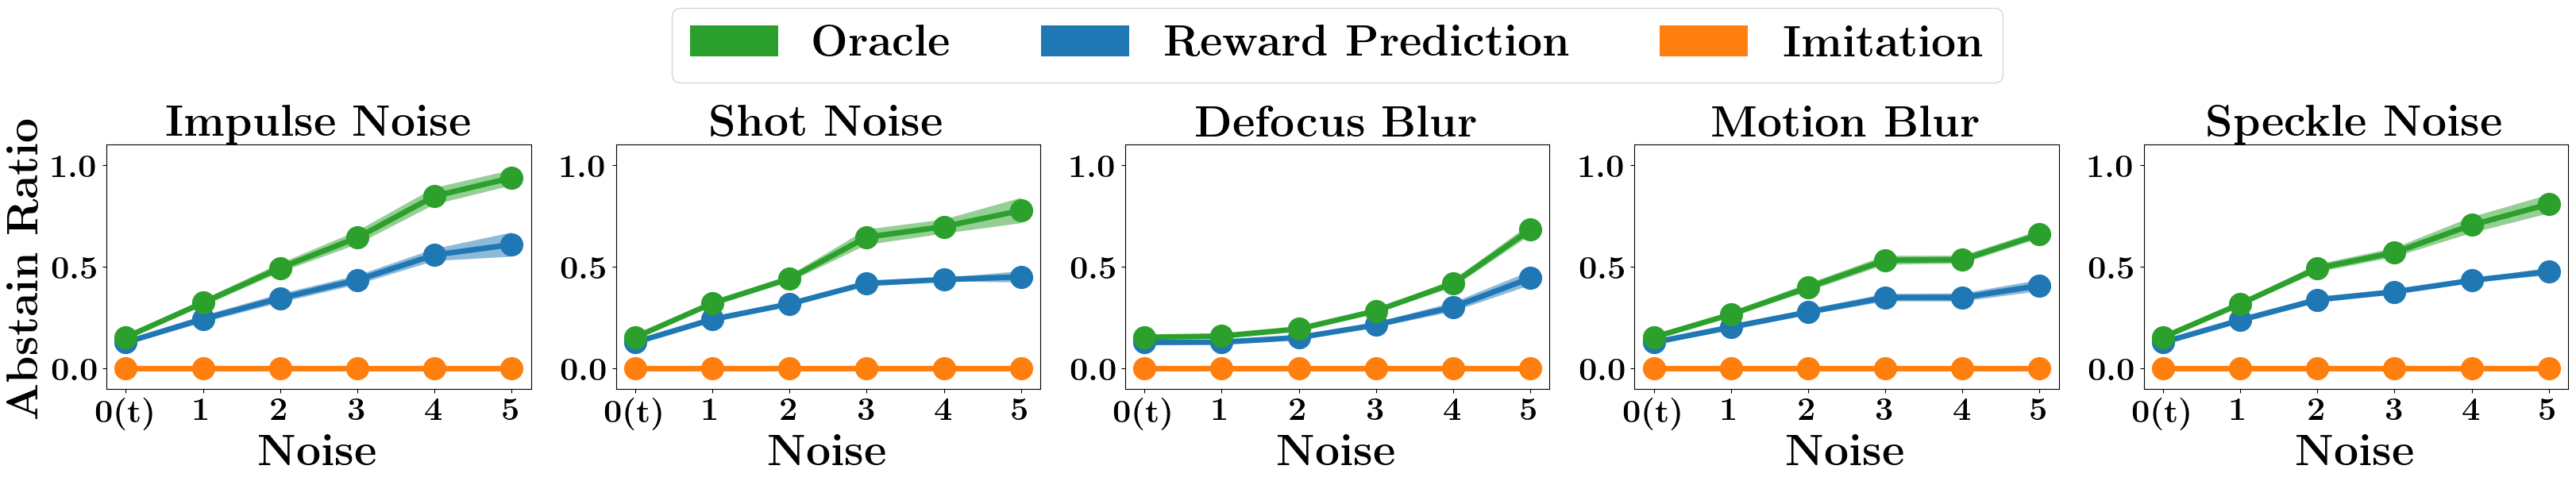

In [52]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
# make subplots with 5 plots horizontally
fig, axs = plt.subplots(1, 5, figsize=(40, 4))


for j in range(5):
    corruption_type = corruption_types[j]

    rl_rewards_seed_corr = np.zeros((5, 6))
    rl_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        rl_run_name = run_names[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}.pkl'.format(rl_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            best_pred_actions = np.argmax(outputs, axis=-1)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            rl_rewards_seed_corr[i, corruption_level] = rewards.mean()
            rl_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()

    bc_rewards_seed_corr = np.zeros((5, 6))
    bc_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        bc_run_name = run_names_imitation[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}.pkl'.format(bc_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            best_pred_actions = np.argmax(outputs, axis=-1)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            bc_rewards_seed_corr[i, corruption_level] = rewards.mean()
            bc_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()

    oracle_rewards_seed_corr = np.zeros((5, 6))
    oracle_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        oracle_run_name = run_names_oracle[i]
        outputs_all = pickle.load(open('data/{}/outputs_{}_ts.pkl'.format(oracle_run_name, corruption_type), 'rb'))
        for corruption_level in range(6):
            outputs = outputs_all[corruption_level]
            outputs = softmax(outputs, axis=-1)
            output_dist_max = outputs.max(axis=-1)
            best_actions = np.argmax(outputs, axis=-1)
            threshold = 4/(1+4)
            certain = (output_dist_max > threshold)
            best_pred_actions = np.array(certain*best_actions + (1-certain)*np.ones(best_actions.shape)*10).astype(int)
            rewards = reward_all[np.arange(len(labels)), best_pred_actions]
            oracle_rewards_seed_corr[i, corruption_level] = rewards.mean()
            oracle_abstain_ratio_seed_corr[i, corruption_level] = (best_pred_actions == 10).mean()
    
    axs[j].plot(np.arange(6), rl_abstain_ratio_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), rl_abstain_ratio_seed_corr.mean(axis=0)-rl_abstain_ratio_seed_corr.std(axis=0), rl_abstain_ratio_seed_corr.mean(axis=0)+rl_abstain_ratio_seed_corr.std(axis=0), alpha=0.5)
    axs[j].plot(np.arange(6), bc_abstain_ratio_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), bc_abstain_ratio_seed_corr.mean(axis=0)-bc_abstain_ratio_seed_corr.std(axis=0), bc_abstain_ratio_seed_corr.mean(axis=0)+bc_abstain_ratio_seed_corr.std(axis=0), alpha=0.5)
    axs[j].plot(np.arange(6), oracle_abstain_ratio_seed_corr.mean(axis=0), 'o-', markersize=20, linewidth=5)
    axs[j].fill_between(np.arange(6), oracle_abstain_ratio_seed_corr.mean(axis=0)-oracle_abstain_ratio_seed_corr.std(axis=0), oracle_abstain_ratio_seed_corr.mean(axis=0)+oracle_abstain_ratio_seed_corr.std(axis=0), alpha=0.5)
    axs[j].set_xticks(np.arange(6), [r'\textbf{0(t)}', r'\textbf{1}', r'\textbf{2}', r'\textbf{3}', r'\textbf{4}', r'\textbf{5}'], fontsize=30)
    axs[j].set_yticks(np.arange(0, 1.5, 0.5),[r'\textbf{'+str(_)+'}' for _ in np.arange(0, 1.5, 0.5)], fontsize=30)
    axs[j].set_xlabel(r'\textbf{Noise}', fontsize=40)
    axs[0].set_ylabel(r'\textbf{Abstain Ratio}', fontsize=40)
    axs[j].set_ylim(-0.1, 1.1)
    axs[j].set_title(corruption_type_labels[j], fontsize=40)

# 
# axs[2].legend(loc="upper center", ncol=3, fontsize=20)
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C2', alpha=1, label=r'\textbf{Oracle}')
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C0', alpha=1, label=r'\textbf{Reward Prediction}')
axs[2].fill_between(np.arange(6), 0, 0, facecolor='C1', alpha=1, label=r'\textbf{Standard Classification}')


# put legend above the figure
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.65), ncol=3, fontsize=40)


# plt.legend(fontsize=15)